In [1]:
import sys 


In [2]:
import tensorflow as tf 
import numpy as np
import os
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import pathlib

DATA: 

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)

In [4]:
IMAGE_SIZE

(256, 256)

In [5]:
PATH='data'
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')


In [6]:
train_ds = image_dataset_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=42,
)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.


In [7]:
train_ds.class_names

['hotdog', 'nothotdog']

In [8]:
category_names = train_ds.class_names

In [9]:
category_names

['hotdog', 'nothotdog']

In [10]:
val_ds = image_dataset_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=42,
    shuffle=True,
)

Found 3000 files belonging to 2 classes.
Using 600 files for validation.


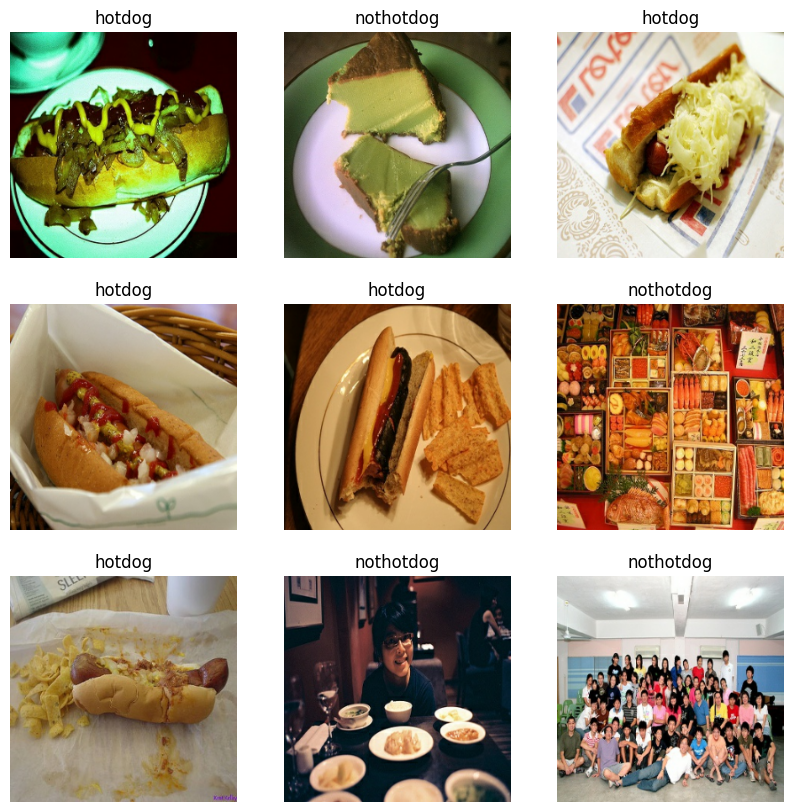

In [11]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(category_names[labels[i]])
        plt.axis('off')

In [12]:
test_ds = image_dataset_from_directory(test_dir,
                                      batch_size=BATCH_SIZE,
                                      image_size=IMAGE_SIZE,
                                      )

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 644 files belonging to 2 classes.


In [13]:
data_augmentation = tf.keras.Sequential(
[
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.3),    
])



In [14]:
#rescale the output to [0,1]
rescale = preprocessing.Rescaling(1./255)

In [15]:
def AlexNet():
    inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
    x = data_augmentation(inputs)
    x = rescale(x)
    x = layers.Conv2D(96, (11, 11), strides=4, activation='relu')(x)
    x = layers.MaxPool2D((3, 3), strides=2)(x)
    x = layers.Conv2D(256, (5, 5), strides=1, padding='same', activation='relu')(x)
    x = layers.MaxPool2D((3, 3), strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(384, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(384, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((3, 3), strides=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs, name='AlexNet')
    return model


In [16]:
model_alexnet = AlexNet()

In [17]:
model_alexnet.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       614656    
                                                           

In [18]:
model_alexnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_alexnet = model_alexnet.fit(train_ds,
                               epochs=8,
                               validation_data=val_ds,
                               callbacks=[callback]
                               )

Epoch 1/8
75/75 [==============================] - 24s 248ms/step - loss: 2.0817 - accuracy: 0.5450 - val_loss: 1.4119 - val_accuracy: 0.5083
Epoch 2/8
75/75 [==============================] - 18s 233ms/step - loss: 1.2070 - accuracy: 0.5596 - val_loss: 4.5717 - val_accuracy: 0.5083
Epoch 3/8
75/75 [==============================] - 18s 236ms/step - loss: 0.7536 - accuracy: 0.5892 - val_loss: 4.8975 - val_accuracy: 0.5083


In [47]:
def graph_learning_curve(history):
    acc = history.history['accuracy']
    acc_val = history.history['val_accuracy']
    
    loss = history.history['loss']
    loss_val = history.history['val_loss']
    
    plt.figure(figsize=(9,9))
    plt.subplot(2,1,1)
    plt.plot(acc, label='Accuracy - Train')
    plt.plot(acc_val, label='Accuracy - Validation')
    plt.legend(loc='upper right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Accuracy - Training & Validation')
    
    plt.figure(figsize=(9,9))
    plt.subplot(2,1,1)
    plt.plot(loss, label='Loss - Train')
    plt.plot(loss_val, label='Loss- Validation')
    plt.legend(loc='lower right')
    plt.ylabel('Loss')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Loss - Training & Validation')
    plt.xlabel('epoch')
    plt.show()

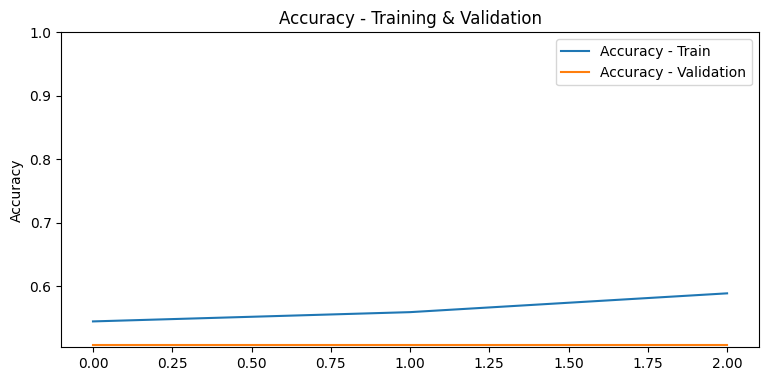

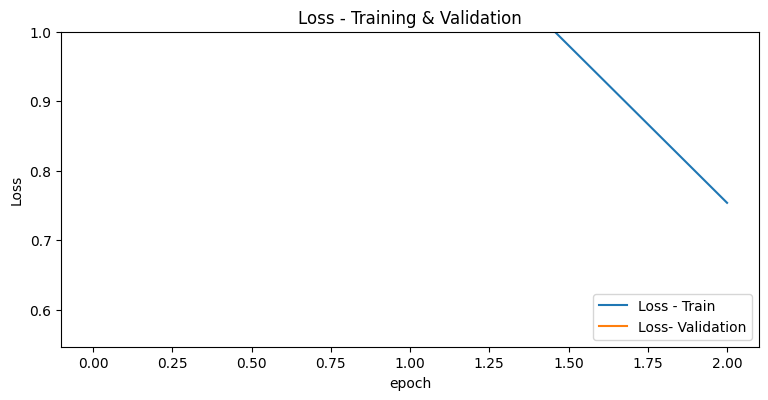

In [20]:
alexnet_learning_plot(history_alexnet)

In [21]:
model_alexnet.evaluate(test_ds)

21/21 [==============================] - 1s 31ms/step - loss: 1.3808 - accuracy: 0.4969


[1.3807569742202759, 0.4968944191932678]

In [41]:
pre_model_vgg19 = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(256,256,3))
pre_model_vgg19.trainable=False


In [42]:
inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.vgg19.preprocess_input(x)
x = pre_model_vgg19(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1)(x)
model_vgg19 = tf.keras.Model(inputs, outputs, name='vgg19')

In [43]:
model_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem_5   (None, 256, 256, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 global_average_pooling2d_5   (None, 512)              0     

In [44]:
model_vgg19.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=['accuracy'])

In [45]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


In [46]:
history_vgg19 = model_vgg19.fit(train_ds,
                               epochs=10,
                               validation_data = val_ds,
                               callbacks=[callback],
                               )

Epoch 1/10
75/75 [==============================] - 34s 422ms/step - loss: 0.9294 - accuracy: 0.8046 - val_loss: 0.4565 - val_accuracy: 0.8933
Epoch 2/10
75/75 [==============================] - 28s 375ms/step - loss: 0.3224 - accuracy: 0.8850 - val_loss: 0.3079 - val_accuracy: 0.8817
Epoch 3/10
75/75 [==============================] - 28s 376ms/step - loss: 0.2199 - accuracy: 0.9158 - val_loss: 0.4264 - val_accuracy: 0.8567
Epoch 4/10
75/75 [==============================] - 28s 372ms/step - loss: 0.2128 - accuracy: 0.9150 - val_loss: 0.2721 - val_accuracy: 0.9017
Epoch 5/10
75/75 [==============================] - 28s 374ms/step - loss: 0.1824 - accuracy: 0.9250 - val_loss: 0.2284 - val_accuracy: 0.9117
Epoch 6/10
75/75 [==============================] - 30s 399ms/step - loss: 0.1914 - accuracy: 0.9229 - val_loss: 0.2129 - val_accuracy: 0.9217
Epoch 7/10
75/75 [==============================] - 28s 372ms/step - loss: 0.1944 - accuracy: 0.9212 - val_loss: 0.2792 - val_accuracy: 0.9067

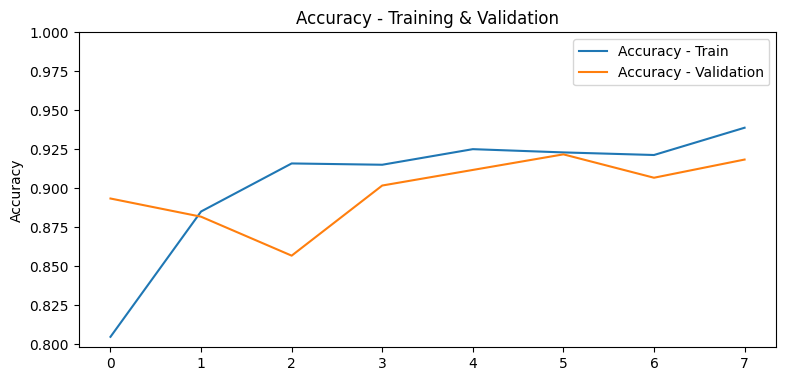

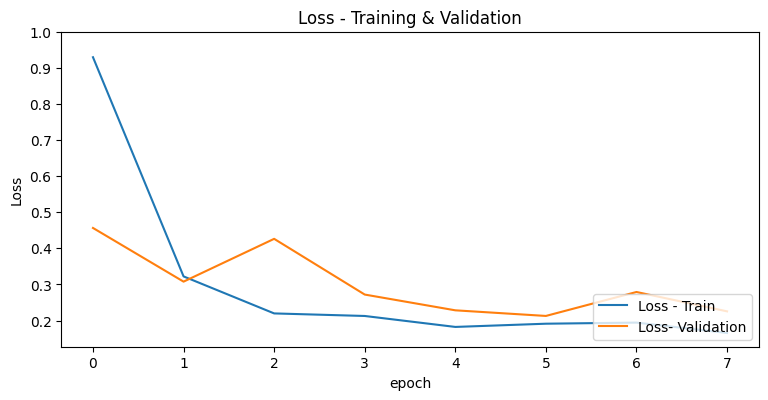

In [48]:
graph_learning_curve(history_vgg19)

In [49]:
#save the model
model_vgg19.save('model_vgg19.h5')

In [50]:
model_vgg19.evaluate(test_ds)

21/21 [==============================] - 5s 213ms/step - loss: 0.2135 - accuracy: 0.9348


[0.21346580982208252, 0.9347826242446899]